In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #matplotlib으로 3D로 표현
from matplotlib import cm #데이터 포인트에 색상 입히기
import numpy as np 


Bad key "text.kerning_factor" on line 4 in
C:\Users\woojung\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#하이퍼파라미터 설정
EPOCHS =10
BATCH_SIZE =64

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("use device:",DEVICE)

use device: cpu


In [4]:
#Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3) # 입력의 측징을 3차원으로 압축
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid() #픽셀당 0과 1사이의 값으로 출력
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE) 
#optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.01, momentum = 0.5)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [7]:
#원본 이미지를 시각화하기(첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255. #모델에 넣었을때 나올 수 있게 전처리

In [8]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        #loss = F.cross_entropy(output, target)
        loss= criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


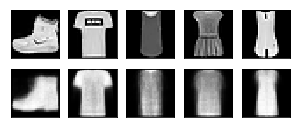

[Epoch 2]


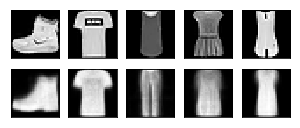

[Epoch 3]


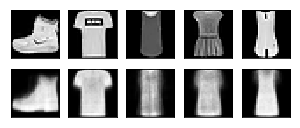

[Epoch 4]


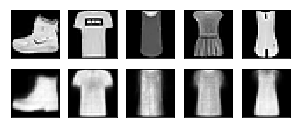

[Epoch 5]


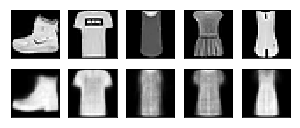

[Epoch 6]


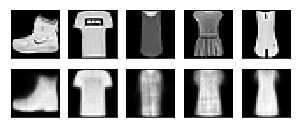

[Epoch 7]


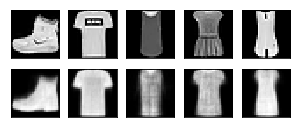

[Epoch 8]


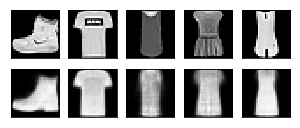

[Epoch 9]


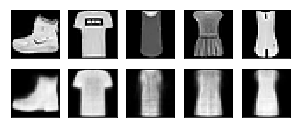

[Epoch 10]


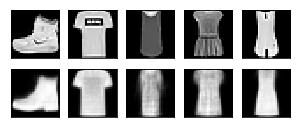

In [9]:
for epoch in range(1, EPOCHS+1):
    train(autoencoder, train_loader)
    
    #디코더에서 나온 이미지를 시각화하기(두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    
    #원본과 디코딩 결과 비교하기
    f, a = plt.subplots(2,5, figsize=(5,2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap = 'gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28,28))
        a[1][i].imshow(img, cmap= 'gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

### 잠재변수 시각화

In [10]:
#잠재변수를 3D 플롯으로 시각화
view_data = trainset.train_data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

C:\Users\woojung\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [11]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

C:\Users\woojung\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


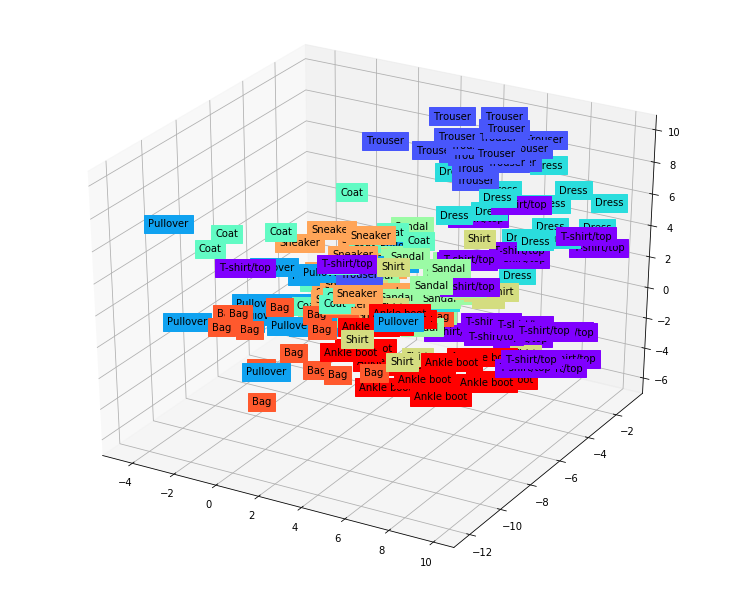

In [12]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:,0].numpy()
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = trainset.train_labels[:200].numpy()

for x,y,z,s in zip(X,Y,Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9)) #비슷한 레이블끼리 비슷한 색깔 나오는것도 확인 가능
    ax.text(x,y,z,name, backgroundcolor = color)
    
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

### 오토인코더의 입력에 잡음을 더해 복원 능력 강화시키기

In [13]:
def train(autoencoder, train_loader, avg_loss):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        #입력에 노이즈 더하기
        x = add_noise(x)
        
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)

        loss= criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() #loss값들의 평균 반환
    return (avg_loss/len(train_loader))

In [14]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [15]:
for epoch in range(1, EPOCHS + 1):
    loss = train(autoencoder, train_loader,0)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.062220653427689315
[Epoch 2] loss:0.0618940328500037
[Epoch 3] loss:0.06174015578653004
[Epoch 4] loss:0.06165521618908148
[Epoch 5] loss:0.06160483279748004
[Epoch 6] loss:0.061490335408399606
[Epoch 7] loss:0.061416988183599294
[Epoch 8] loss:0.0613812821657101
[Epoch 9] loss:0.06142298795028663
[Epoch 10] loss:0.061396812039143496


In [16]:
## 이미지 복원 시각화하기 
testset = datasets.FashionMNIST(
    root = './.data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [17]:
#시각화를 위하여 testset에서 사진 하나 가지고오기 ->  전처리
sample_data = testset.test_data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

C:\Users\woojung\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [18]:
#이미지를 add_noise로 오염시킨 후, 모델 통과
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

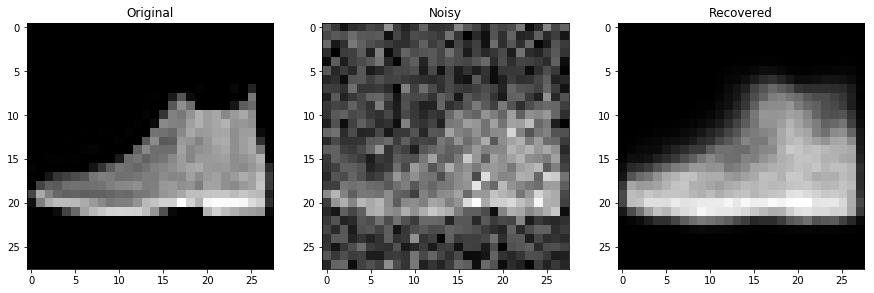

In [19]:
f,a = plt.subplots(1,3, figsize =(15,15))

#시각화를 위해 넘파이 행렬로 바꾸기
original_img = np.reshape(original_x.to("cpu").data.numpy(),(28,28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(),(28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(),(28,28))

#원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')
#오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')
#복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')